# Lale: Types and Auto-ML for Scikit-learn

This notebook is an introductory guide to
[Lale](https://github.com/ibm/lale) for scikit-learn users.
[Scikit-learn](https://scikit-learn.org) is a popular, easy-to-use,
and comprehensive data science library for Python. This notebook aims
to show how Lale can make scikit-learn even better in two areas: type
checking and auto-ML.  First, when you pass hyperparameters or
datasets to scikit-learn, Lale checks that these are
type-correct. Second, if you do not want to manually select all
algorithms or tune all hyperparameters, you can leave it to Lale to do
that for you automatically. For both type-checking and auto-ML, Lale
uses a single source of truth: machine-readable schemas associated
with scikit-learn compatible transformers and estimators. Rather than
invent a new schema specification language, Lale uses [JSON
Schema](https://json-schema.org/understanding-json-schema/), because
it is popular, widely-supported, and makes it easy to store or send
hyperparameters as JSON objects. Furthermore, by using the same
schemas both for type-checking and for auto-ML, Lale ensures that
type-checking is consistent with auto-ML while also making schemas
easier to maintain.

Lale is an open-source Python library and you can install it by doing
`pip install lale`. See
[installation](https://github.com/IBM/lale/blob/master/docs/installation.rst)
for further instructions. Lale uses the term *operator* to refer to
what scikit-learn calls machine-learning transformer or estimator.
Lale provides schemas for 144
[operators](https://github.com/IBM/lale/tree/master/lale/lib). Most of
these operators come from scikit-learn itself, but there are also
operators from other frameworks such as XGBoost, PyTorch, and even [R
and Weka](https://github.com/IBM/lale-gpl/tree/master/lalegpl/lib).
If Lale does not yet support your favorite operator, you can add it
yourself by following this
[guide](https://nbviewer.jupyter.org/github/IBM/lale/blob/master/examples/docs_new_operators.ipynb). If
you do add a new operator, please consider contributing it back to
Lale!

The rest of this notebook first introduces schemas, then demonstrates
how to use them for type-checking, and finally demonstrates how to use
the same schemas for auto-ML.

### Looking at Schemas from a Notebook

When writing data science code, I sometimes don't remember all the API
information about what hyperparameters and datasets an operator
expects. Lale attaches this information to the operators, so we can
look it up interactively in a notebook. To demonstrate, let's first
import two scikit-learn operators, a decision tree estimator and an
NMF transformer. The function `wrap_imported_operators` augments these
two operators with schemas.

In [1]:
from lale.lib.sklearn import DecisionTreeRegressor as Tree
from sklearn.decomposition import NMF
import lale.helpers
lale.helpers.wrap_imported_operators()

Scikit-learn has excellent online documentation, and Lale stores a
link to that.

In [2]:
print(Tree.documentation_url())

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


Lale provides a helper function `ipython_display` that pretty-prints
JSON documents and JSON schemas in a Jupyter notebook. You can get a
quick overview of the constructor arguments of an operator by calling
the `hyperparam_defaults` method.

In [3]:
from lale.pretty_print import ipython_display
ipython_display(Tree.hyperparam_defaults())

```python
{
    'criterion': 'mse',
    'splitter': 'best',
    'max_depth': null,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': null,
    'random_state': null,
    'max_leaf_nodes': null,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': null,
    'presort': false}
```

Hyperparameters can be categorical (meaning they accept a few
discrete values) or continuous (integers or real numbers).
As an example for a categorical hyperparameter, let's look at the
`criterion`. JSON Schema can encode categoricals as an `enum`.

In [4]:
ipython_display(Tree.hyperparam_schema('criterion'))

```python
{
    'description': 'Function to measure the quality of a split.',
    'enum': ['mse', 'friedman_mse', 'mae'],
    'default': 'mse'}
```

As an example for a continuous hyperparameter, let's look at
`max_depth`. The decision tree regressor in scikit-learn accepts
either an integer for that, or `None`, which has its own meaning.
JSON Schema can express these two choices as an `anyOf`.  Also, while
any positive integer is a valid value, in the context of auto-AI,
Lale specifies a bounded range for the optimizer to search over.

In [5]:
ipython_display(Tree.hyperparam_schema('max_depth'))

```python
{
    'description': 'Maximum depth of the tree.',
    'default': null,
    'anyOf': [
    {   'type': 'integer',
        'minimum': 1,
        'minimumForOptimizer': 3,
        'maximumForOptimizer': 5},
    {   'enum': [null],
        'description': 'If None, then nodes are expanded until all leaves are pure, or until all leaves contain less than min_samples_split samples.'}]}
```

Besides hyperparameter schemas, Lale also provides dataset
schemas. For exampe, NMF requires a non-negative matrix as `X`. In
JSON Schema, we express this as an array of arrays of numbers with
`minimum: 0`.  While NMF also accepts a second argument `y`, it does
not use that argument. Therefore, Lale gives `y` the empty schema
`{}`, which permits any values.

In [6]:
ipython_display(NMF.input_schema_fit())

```python
{
    'type': 'object',
    'required': ['X'],
    'additionalProperties': false,
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number',
                    'minimum': 0.0}}},
        'y': {}}}
```

### Hyperparameter Error Example in Scikit-Learn

To set the stage for how Lale uses schemas for error checking, let's
look at how scikit-learn does error-checking without schemas. First,
we import a few things.

In [7]:
import sys
import sklearn
from sklearn import pipeline, feature_selection, ensemble, tree

We use `make_pipeline` to compose a pipeline of two steps: an RFE
transformer and a decision tree regressor. RFE performs recursive
feature elimination, keeping only those features of the input data
that are the most useful for its `estimator` argument. For RFE's
estimator argument, the following code uses a random forest with 10
trees.

In [8]:
sklearn_hyperparam_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.tree.DecisionTreeRegressor(max_depth=-1))

Recall that the `max_depth` argument for a decision tree cannot be a
negative number. Hence, the above code actually contains a bug: it
sets `max_depth=-1`. Scikit-learn does not check for this mistake from
the `__init__` method, otherwise we would have seen an error message
already. Instead, scikit-learn checks for this mistake during `fit`.
In order to call `fit`, we must first load a dataset. We load the
California Housing dataset and display the first few rows to get a
feeling for the data. Lale can process both Pandas dataframes and
Numpy ndarrays; here we use dataframes.

In [9]:
import pandas as pd
import lale.datasets
(train_X, train_y), (test_X, test_y) = lale.datasets.california_housing_df()
pd.concat([train_X.head(), train_y.head()], axis=1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


Now that we have data, we can train our pipeline. As expected, since
we deliberately had a mistake in the hyperparameters, training fails.
However, it takes a few seconds to get the exception, because
scikit-learn first trains the RFE transformer and uses it to transform
the data. Only then does it pass the data to the decision tree.

In [10]:
%%time
try:
    sklearn_hyperparam_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 4.17 s, sys: 78.1 ms, total: 4.25 s
Wall time: 4.28 s


max_depth must be greater than zero. 


In [11]:
assert message.startswith("max_depth must be greater than zero.")

Fortunately, this error message is pretty clear. Scikit-learn
implements the error check imperatively, using Python if-statements
to raise an exception when hyperparameters are configured wrong.

### Checking Hyperparameters with Types

Lale performs the same error checks, but using JSON Schema validation
instead of Python if-statements and raise-statements. First, we import
a few things.

In [12]:
import lale.operators
import jsonschema

Below is the exact same pipeline as before, but written in Lale
instead of directly in scikit-learn. In both cases, the underlying
implementation is in scikit-learn; Lale only adds thin wrappers to
support type checking and auto-ML. This example uses fully-qualified
names (e.g., `lale.lib.sklearn.RFE`) to make it clear which version of
the operator is being used. The fully-qualified names are for
presentation purposes only; in typical usage of either scikit-learn or
Lale, these would be simple names (e.g. just `RFE`).

In [13]:
%%time
try:
    lale_hyperparam_error = lale.operators.make_pipeline(
        lale.lib.sklearn.RFE(
            estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
        lale.lib.sklearn.DecisionTreeRegressor(max_depth=-1))
except jsonschema.ValidationError as e:
    message = e.message
print(message, file=sys.stderr)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 25 ms


Invalid configuration for DecisionTreeRegressor(max_depth=-1) due to invalid value max_depth=-1.
Schema of argument max_depth: {
    'description': 'Maximum depth of the tree.',
    'default': null,
    'anyOf': [
    {   'type': 'integer',
        'minimum': 1,
        'minimumForOptimizer': 3,
        'maximumForOptimizer': 5},
    {   'enum': [null],
        'description': 'If None, then nodes are expanded until all leaves are pure, or until all leaves contain less than min_samples_split samples.'}]}
Value: -1


In [14]:
assert message.startswith("Invalid configuration for DecisionTreeRegressor(max_depth=-1)")

Just like in the scikit-learn example, the error message in the Lale
example also pin-points the problem as passing `max_depth=-1` to the
decision tree. It does so in a more stylized way, printing the
relevant JSON schema for this hyperparameter.  Lale detects the error
already when the wrong hyperparameter is being passed as an argument,
thus reducing the amount of code you have to look at to find the root
cause.  Furthermore, Lale takes only tens of milliseconds to detect
the error, because it does not attempt to train the RFE transformer
first. In this example, that only saves a few seconds, which may not
be significant. But there are situations with larger time savings,
such as when using larger datasets, slower operators, or when auto-ML
tries out many pipelines.

### Dataset Error Example in Scikit-Learn

Above, we saw an example for detecting a hyperparameter error in
scikit-learn and in Lale. Next, we look at an analogous example for a
dataset error. Again, let's first look at the experience with
scikit-learn and then the same thing with Lale.

In [15]:
from sklearn import decomposition

We use scikit-learn to compose a pipeline of two steps: an RFE
transformer as before, this time followed by an NMF transformer.

In [16]:
sklearn_dataset_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.decomposition.NMF())

NMF, or non-negative matrix factorization, does not allow any negative
numbers in its input matrix. The California Housing dataset contains
some negative numbers and the RFE does not eliminate those features.
To detect the mistake, scikit-learn must first train the RFE and
transform the data with it, which takes a few seconds. Then, NMF
detects the error and throws an exception.

In [17]:
%%time
try:
    sklearn_dataset_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 4.31 s, sys: 109 ms, total: 4.42 s
Wall time: 4.58 s


Negative values in data passed to NMF (input X)


In [18]:
assert message.startswith("Negative values in data passed to NMF (input X)")

### Types for Dataset Checking

Lale uses types (as expressed using JSON schemas) to check dataset
related mistakes. Below is the same pipeline as before, using thin
Lale wrappers around scikit-learn operators.

In [19]:
lale_dataset_error = lale.operators.make_pipeline(
    lale.lib.sklearn.RFE(
        estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
    lale.lib.sklearn.NMF())

Instead of calling `fit` on the pipeline, we call `validate_schema`.
This does not perform training, but rather, just checks that the
schema is correct at each step of the pipeline. In other words, it
checks whether the schema of the input data is valid for the first
step of the pipeline, and that the schema of the output from each step
is valid for the next step. By saving the time for training the RFE,
this completes in tens of milliseconds instead of seconds as before.

In [20]:
%%time
try:
    lale_dataset_error.validate_schema(train_X, train_y)
except lale.helpers.SubschemaError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 78.1 ms, sys: 15.6 ms, total: 93.8 ms
Wall time: 92.4 ms


Expected to_schema(data) to be a subschema of NMF.input_schema_fit().
to_schema(data) = {
    'type': 'object',
    'additionalProperties': false,
    'required': ['X', 'y'],
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number'}}},
        'y': {
            'type': 'array',
            'minItems': 16512,
            'maxItems': 16512,
            'items': {
                'description': 'target',
                'type': 'number'}}}}
NMF.input_schema_fit() = {
    'type': 'object',
    'required': ['X'],
    'additionalProperties': false,
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number',
                    'minimum': 0.0}}},
        'y': {}}}


In [21]:
assert message.startswith('Expected to_schema(data) to be a subschema of NMF.input_schema_fit().')

In this example, the schemas for `X` differ: whereas the data is an
array of arrays of unconstrained numbers, NMF expects an array of
arrays of only non-negative numbers.

### Types for Hyperparameter Tuning

We have already seen that Lale uses schemas for interactive
documentation and for error-checking. Now we will see how Lale uses
those same schemas for auto-ML. Specifically, we will start by looking
at hyperparameter tuning, which is an important sub-task of auto-ML.
First, let's import PCA, another transformer from scikit-learn, and
HyperoptRegressor, a Lale interface to the
[hyperopt](http://hyperopt.github.io/hyperopt/) auto-ML library.

In [22]:
from sklearn.decomposition import PCA
from lale.lib.lale import HyperoptRegressor
lale.helpers.wrap_imported_operators()

Next, we create a two-step pipeline of PCA and a decision tree
regressor. Note that we are not specifying any hyperparameters for
these two operators. The code just says `PCA, Tree` instead of
`PCA(...), Tree(...)`. This is on purpose: rather than binding
hyperparameters by hand, we leave them free to be tuned by hyperopt.

In [23]:
pca_tree_planned = lale.operators.make_pipeline(PCA, Tree)

When we create an instance of `HyperoptRegressor`, we pass in the
pipeline as its `estimator` argument. Then, we call `fit` to search
for a good pipeline. In this case, the search uses 10 trials. Each
trial draws values for the hyperparameters from the ranges specified
by the JSON schemas associated with the operators in the pipeline.

In [24]:
pca_tree_hyperopt = HyperoptRegressor(estimator=pca_tree_planned, cv=3, max_evals=10)
pca_tree_trained = pca_tree_hyperopt.fit(train_X, train_y)

100%|██████████| 10/10 [00:06<00:00,  2.12it/s, best loss: -0.4696652802026405]


The end result is the pipeline that performed best in cross-validation
out of the 10 trials. In addition to the cross-val score, we can also
evaluate this best pipeline against the test data. We simply reuse the
existing R2 score metric from scikit-learn for this purpose.

In [25]:
predicted = pca_tree_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.47


### Inspecting the Results of Automation

In the previous example, the automation picked hyperparameter values
for PCA and the decision tree. We know the values were valid and we
know how well the pipeline performed with them. But we might also want
to know exactly which values were picked. One way to do that is by a
tooltip in the visualization. If you are looking at this notebook in a
viewer that supports tooltips, you can hover the mouse pointer over
either one of the operators to see its hyperparameters.

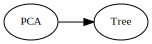

In [26]:
lale.helpers.to_graphviz(pca_tree_trained._impl)

Another way to view the results of hyperparameter tuning in Lale is by
pretty-printing the pipeline as Python source code. The code contains
the hyperparameters. It also uses the `>>` symbol, which is just
syntactic sugar for calling the `make_pipeline` function.

In [27]:
ipython_display(pca_tree_trained._impl, show_imports=False)

```python
pca = PCA(whiten=True)
tree = Tree(max_depth=3, max_features='log2', min_samples_leaf=13, min_samples_split=10)
pipeline = pca >> tree
```

### Using Lale with GridSearchCV

Lale supports multiple auto-ML tools, not just hyperopt. For instance,
you can also use
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
from scikit-learn. Just like with hyperopt, Lale uses your planned
pipeline along with the schemas for its operators to generate a search
space.

In [28]:
from lale.search.GridSearchCV import LaleGridSearchCV
grid_search_grid = LaleGridSearchCV(
    pca_tree_planned, lale_num_samples=1, lale_num_grids=1, cv=2,
    scoring=sklearn.metrics.make_scorer(sklearn.metrics.r2_score))

To run the search, you call `fit` and provide the training data.

In [29]:
%%time
grid_search_best = grid_search_grid.fit(train_X, train_y).best_estimator_.to_lale()

CPU times: user 8.52 s, sys: 3.53 s, total: 12 s
Wall time: 5.83 s


You can inspect the results, for instance, by pretty-printing the best
pipeline found by grid search back as Python source code.

In [30]:
ipython_display(grid_search_best, show_imports=False)

```python
pca = PCA(n_components=5e-324, svd_solver='full', whiten=True)
tree = Tree(max_depth=3, max_features=5e-324, min_samples_split=0.01, splitter='random')
pipeline = pca >> tree
```

Also, you can use the best pipeline found for scoring and evaluate the
quality of the predictions.

In [31]:
predicted = grid_search_best.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score -0.00


### Pipeline Combinators

We already saw that `>>` is syntactic sugar for `make_pipeline`.  Lale
refers to `>>` as the *pipe* combinator. Besides `>>`, Lale supports
two additional combinators. Before we introduce them, we will import a
few more things.

In [32]:
from lale.lib.lale import NoOp
from lale.lib.lale import ConcatFeatures as HStack
from sklearn.linear_model import LinearRegression as LinReg
from xgboost import XGBRegressor as XGBoost
lale.helpers.wrap_imported_operators()

First, let's compose a pipeline using scikit-learn style functions.
We already saw `make_pipeline`. Function `make_union` also exists in
scikit-learn. It composes multiple sub-pipelines to run on the same
data, then concatenates the features. In other words, `make_union`
produces a horizontal stack of the data transformed by its
sub-pipelines. Function `make_choice` does not exist in scikit-learn.
It specifies an algorithmic choice, which auto-ML can resolve. In
other words, `make_choice` creates a search space for automated
algorithm selection.

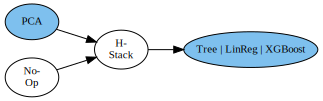

In [33]:
dag_with_functions = lale.operators.make_pipeline(
    lale.operators.make_union(PCA, NoOp),
    lale.operators.make_choice(Tree, LinReg, XGBoost))
lale.helpers.to_graphviz(dag_with_functions)

The visualization shows `make_union` as multiple sub-pipelines feeding
into `HStack`, and it shows `make_choice` using an `|` combinator. In
total, Lale has three combinators. We already saw `>>` (pipe) and `|`
(or). The third combinator is `&` (and). The next example shows the
exact same pipeline as before, but written using combinators instead
of functions.

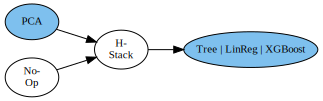

In [34]:
dag_with_combinators = (PCA & NoOp) >> HStack >> (Tree | LinReg | XGBoost)
lale.helpers.to_graphviz(dag_with_combinators)

### Combined Algorithm Selection and Hyperparameter Optimization

Since the `dag_with_functions` specifies an algorithm choice, when we
feed it to a `HyperoptRegressor`, Hyperopt will do algorithm selection
for us. And since some of the operators in the dag do not have all
their hyperparameters bound, hyperopt will also tune their free
hyperparameters for us.

In [35]:
multi_alg_hyperopt = HyperoptRegressor(estimator=dag_with_functions, cv=3, max_evals=10)
multi_alg_trained = multi_alg_hyperopt.fit(train_X, train_y)

100%|██████████| 10/10 [01:37<00:00,  8.46s/it, best loss: -0.7778059793292099]


We can visualize the resulting trained pipeline to see what algorithms
hyperopt chose. Also, recall that you can hover the mouse pointer over
operators in the visualization to see a tooltip with their
hyperparameters.

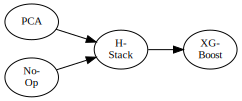

In [36]:
lale.helpers.to_graphviz(multi_alg_trained._impl)

Of course, the trained pipeline can be used for predictions as usual,
and we can use scikit-learn metrics to evaluate those predictions.

In [37]:
predicted = multi_alg_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.79


### Hyperparameter Constraint Example in Scikit-Learn

Sometimes, the validity of hyperparameters cannot be checked in
isolation. Instead, the value of one hyperparameter can restrict
which values are valid for another hyperparameter. For example,
scikit-learn imposes a conditional hyperparameter constraint between
the `svd_solver` and `n_components` arguments to PCA.

In [38]:
sklearn_constraint_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.decomposition.PCA(svd_solver='arpack', n_components='mle'))

The above notebook cell completed successfully, because scikit-learn
did not yet check for the constraint. To observe the error message
with scikit-learn, we must attempt to fit the pipeline.

In [39]:
%%time
message=None
try:
    sklearn_constraint_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 4.25 s, sys: 125 ms, total: 4.38 s
Wall time: 4.46 s


n_components='mle' cannot be a string with svd_solver='arpack'


In [40]:
assert message.startswith("n_components='mle' cannot be a string with svd_solver='arpack'")

Scikit-learn implements constraint-checking as Python code with
if-statements and raise-statements. After a few seconds, we get an
exception, and the error message explains what went wrong.

### Types for Constraint Checking

Lale specifies constraints using JSON Schemas. When you configure an
operator with actual hyperparameters, Lale immediately validates them
against their schema including constraints.

In [41]:
%%time
try:
    lale_constraint_error = lale.operators.make_pipeline(
        lale.lib.sklearn.RFE(
            estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
        PCA(svd_solver='arpack', n_components='mle'))
except jsonschema.ValidationError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 44.8 ms


Invalid configuration for PCA(svd_solver='arpack', n_components='mle') due to constraint option n_components mle can only be set for svd_solver full or auto.
Schema of constraint 1: {
    'description': 'Option n_components mle can only be set for svd_solver full or auto.',
    'anyOf': [
    {   'type': 'object',
        'properties': {
            'n_components': {
                'not': {
                    'enum': ['mle']}}}},
    {   'type': 'object',
        'properties': {
            'svd_solver': {
                'enum': ['full', 'auto']}}}]}
Value: {'svd_solver': 'arpack', 'n_components': 'mle', 'copy': True, 'whiten': False, 'tol': 0.0, 'iterated_power': 'auto', 'random_state': None}


In [42]:
assert message.startswith("Invalid configuration for PCA(svd_solver='arpack', n_components='mle')")

Lale reports the error quicker than scikit-learn, taking only tens of
milliseconds instead of multiple seconds. The error message contains
both a natural-language description of the constraint and its formal
representation in JSON Schema. The `'anyOf'` implements an 'or', so
you can read the constraints as

```python
(not (n_components in ['mle'])) or (svd_solver in ['full', 'auto'])
```

By basic Boolean algebra, this is equivalent to an implication

```python
(n_components in ['mle']) implies (svd_solver in ['full', 'auto'])
```

Since the constraint is specified declaratively in the schema, it gets
applied wherever the schema gets used. Specifically, the constraint
gets used both for type-checking and for auto-ML. In the context of
auto-ML, the constraint prunes the search space: it eliminates some
hyperparameter combinations so that the auto-ML tool does not have to
try them out. We have observed cases where this pruning makes a big
difference in search convergence.

### FAQ

- Q: Can I implement other tasks besides regression?

  A: Yes, for instance, you can use HyperoptClassifier for
     classification.

- Q: How about other modalities besides tables?

  A: Besides table, we have successfully used Lale for text, images,
     and time-series. In fact, Lale even works for multi-modal data,
     using the `&` combinator to specify different preprocessing paths
     per modality.

- Q: I get an error when I instantiate an operator imported from Lale.

  A: Lale raises errors on invalid hyperparameter values or
     combinations. This ensures that the operators are used correctly.
     So don't be surprised if you get any errors when you initialize
     Lale operators with some hyperparameter values. Chances are that
     those hyperpameters or combinations of hyperparameters are
     invalid. If not, please contact us.

- Q: The algorithm I want to use is not present in Lale. Can I still use it?

  A: Some of the features of Lale can be used if the algorithm
     implementation follows a scikit-learn API of fit/predict or
     fit/transform. You can cast the operator into a Lale operator as
     follows:

     ```
     from lale.operators import make_operator
     lale_op = make_operator(non_lale_op)
     ```

- Q: Can I tweak the schema of an operator?

  A: Yes, by calling the `customize_schema` method. There is a
     separate
     [guide](https://github.com/IBM/lale/blob/master/examples/docs_new_operators.ipynb)
     for how to do that.

- Q: How does the search space generation work?

  A: Lale includes a search space generator that takes in a planned
     pipeline and the schemas of the operators in that pipeline, and
     returns a search space for your auto-ML tool of choice. Our
     [arXiv paper](https://arxiv.org/pdf/1906.03957.pdf) describes how
     that works in detail.

- Q: Does Lale optimize for computational performance?

  A: While Lale focuses mostly on types and automation, we have also
     done a little bit of work on computational performance. However,
     it has not been a major focus. If you encounter major
     pain-points, please reach out to us.
